In [1]:
import os
import shutil

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import quantile_transform
from sklearn import preprocessing

nltk.download('punkt');
nltk.download('wordnet');
nltk.download('stopwords');

from utils import *

c:\Users\Simon Andersen\miniconda3\envs\BigData\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to C:\Users\Simon
[nltk_data]     Andersen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Simon
[nltk_data]     Andersen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Simon
[nltk_data]     Andersen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
data = pd.read_csv('data.csv')
val = pd.read_csv('data/val.csv', names=['text'])
# convert text column to strings
data['text'] = data['text'].astype(str)

N = data.shape[0]

print('Number of conversations: ', N)
print("Columns in conversations.csv: ", list(data.columns))

Number of conversations:  5429
Columns in conversations.csv:  ['text', 'label']


In [10]:
features = preprocess(data, save=True)
val_features = preprocess(val, save=False)

In [8]:


pca = PCA(n_components=2)

data_X = data.drop(['label'], axis=1) #We are not going to use the target for unsupervised learning
X = quantile_transform(data_X, copy=True)

X_new = pca.fit_transform(X)
X_val = quantile_transform(val, copy=True)
X_val = pca.fit_transform(X_val)
df_val = pd.DataFrame(data = X_val
             , columns = ['PC 1', 'PC 2'])


df_X = pd.DataFrame(data = X_new
             , columns = ['PC 1', 'PC 2'])
df_y = pd.DataFrame(data = data['label'], columns = ['label'])

finalDf = pd.concat([df_X, data['label']], axis = 1)
finalDf.head()

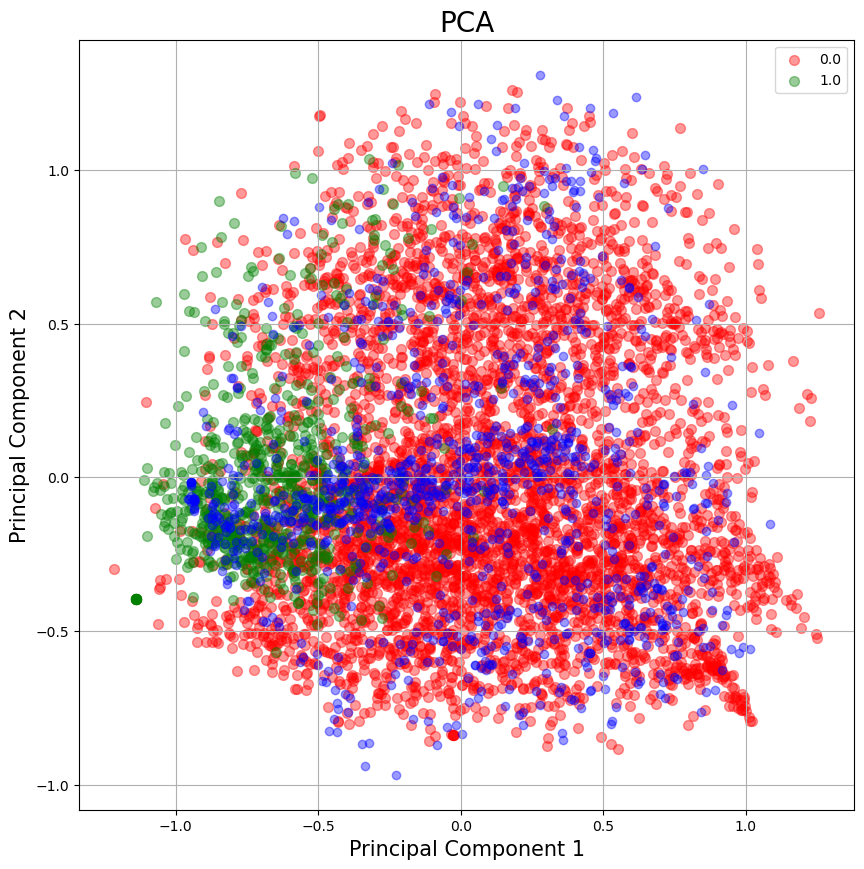

In [42]:
# Show the graphics.
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA', fontsize = 20)
targets = [0.0, 1.0]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC 1']
               , finalDf.loc[indicesToKeep, 'PC 2']
               , c = color
               , s = 50, alpha=.4)
ax.scatter(df_val.loc[:,'PC 1'], df_val.loc[:,'PC 2'],color='blue', alpha=.4)
ax.legend(targets)
ax.grid()

In [60]:
# a quick function for plotting our PCA components
def plot_pca(y_pcs, y, fig = None, ax = None):
    #=== plot PCA results
    if fig is None and ax is None:
        fig, ax = plt.subplots(1, figsize=(5, 5), dpi=100)
    #ax.set_xlim(np.percentile(y_pcs[:,0], 99), np.percentile(y_pcs[:,0], 1))
    #ax.set_ylim(np.percentile(y_pcs[:,1], 99), np.percentile(y_pcs[:,1], 1))
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')

    # locate the points of each type in the original data
    # and paint them over the transformed data
    is_type1 = (y == 0)
    is_type2 = (y == 1)
    ax.scatter(y_pcs[is_type1, 0], y_pcs[is_type1, 1], 
               c='r', marker='o', s = 3, label='Type 1', alpha=.3)
    ax.scatter(y_pcs[is_type2, 0], y_pcs[is_type2, 1], 
               c='g', marker='o', s=3, label='Type 2', alpha=.3)
    ax.legend()
    #plt.show()
    return 

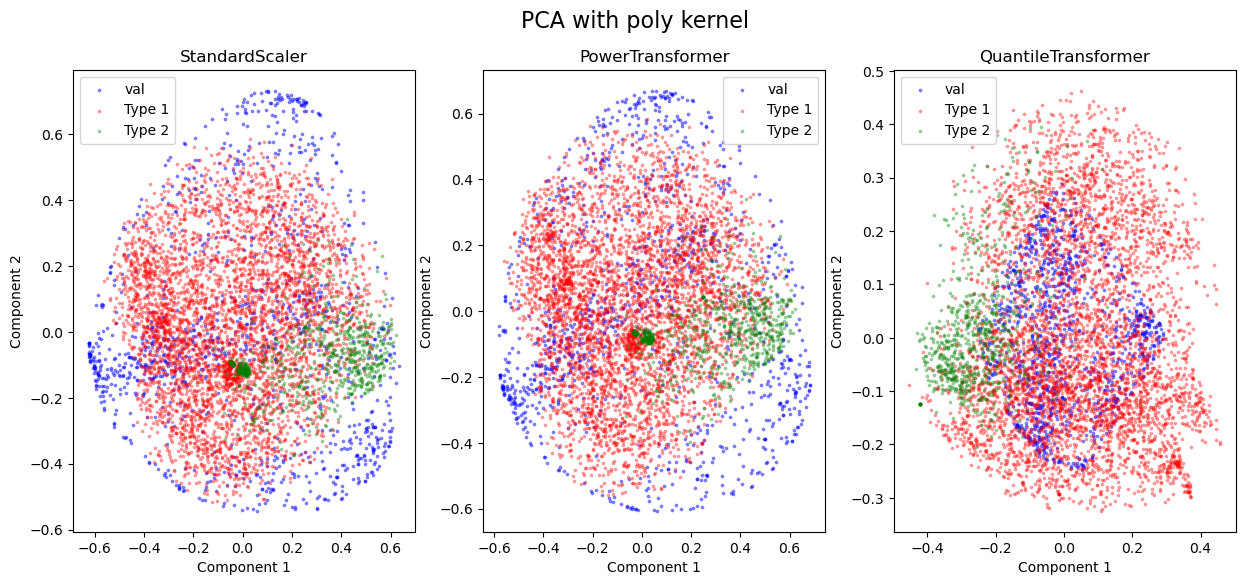

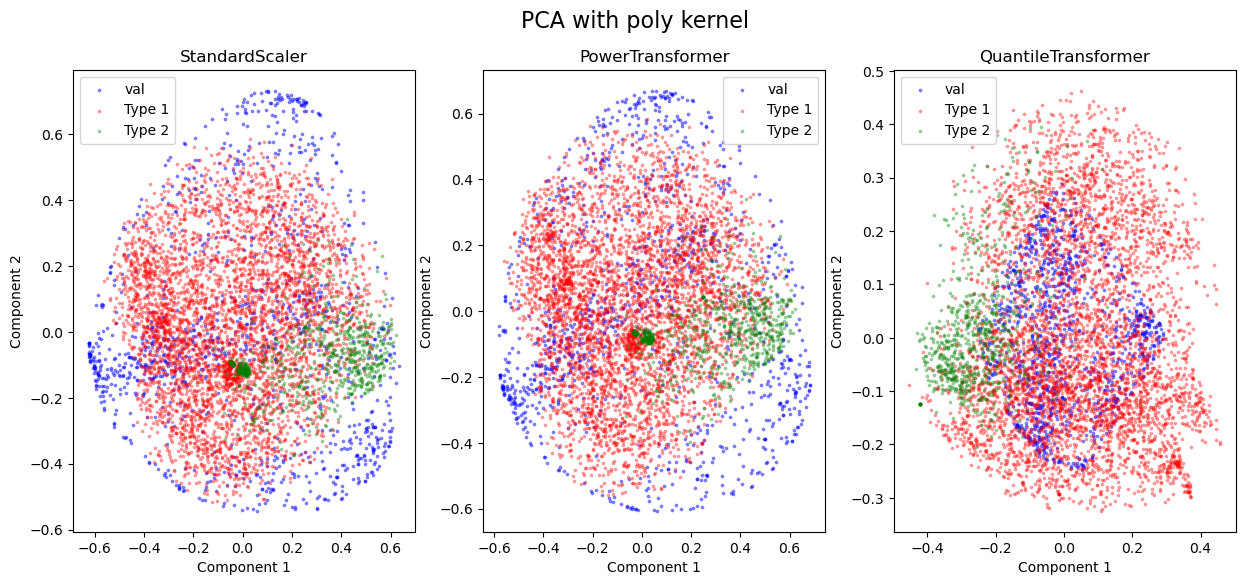

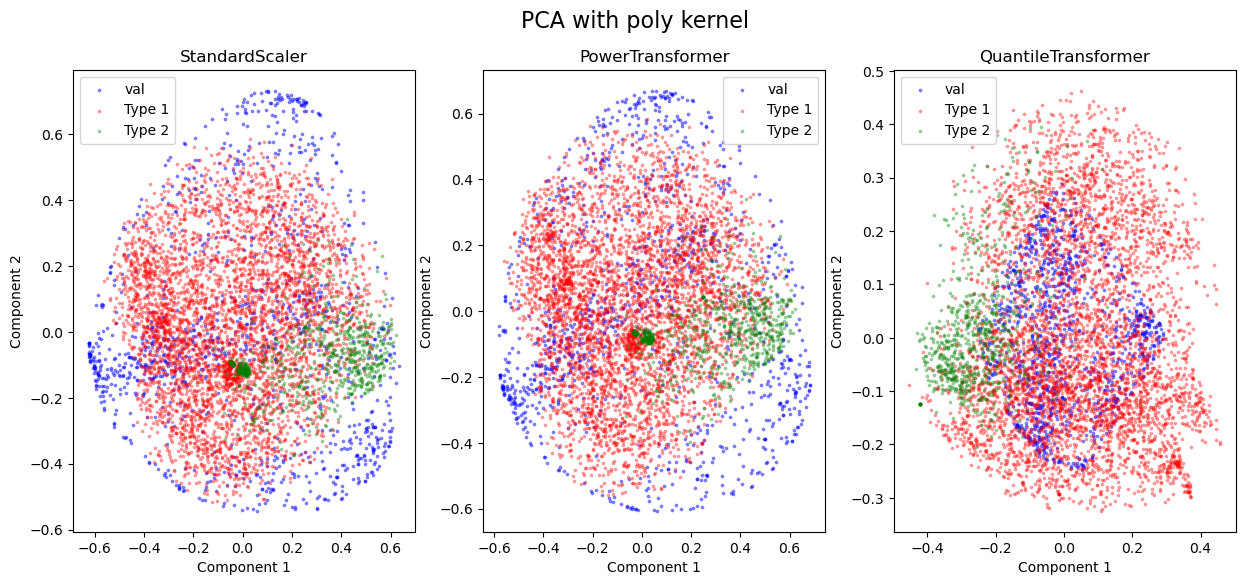

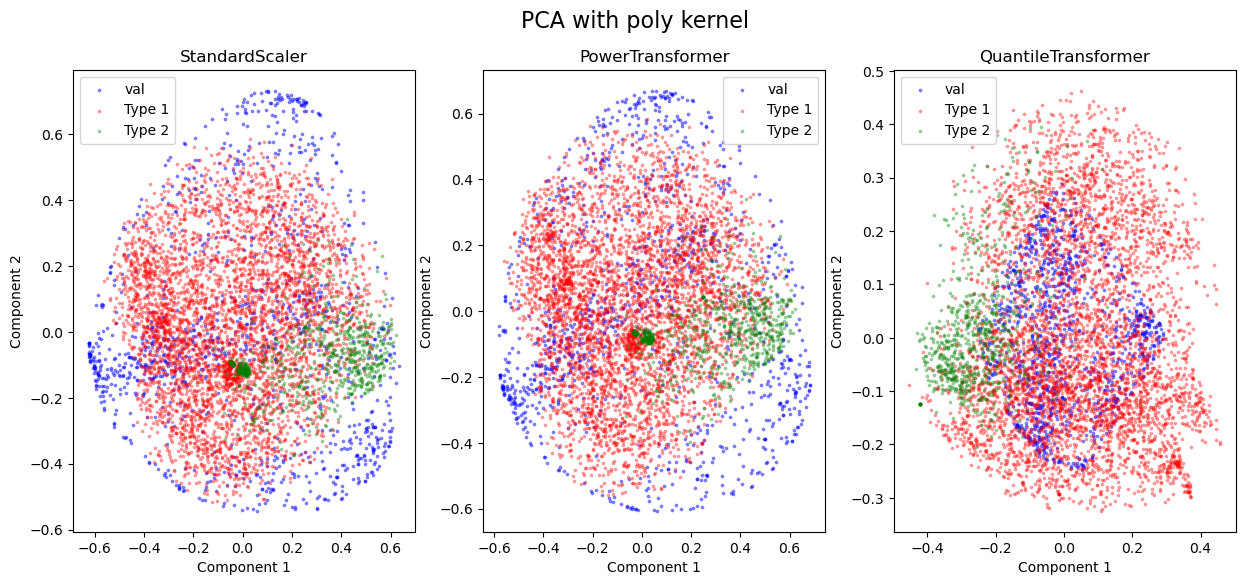

In [66]:
# standardize X using a variety of preprocessing schemes
pca_kernel_list = [KernelPCA(n_components=2,kernel='linear'), KernelPCA(n_components=2,kernel='rbf'),
                   KernelPCA(n_components=2,kernel='poly'), KernelPCA(n_components=2,kernel='cosine')]
kernel_name_list = ['linear', 'rbf', 'poly', 'cosine']
for transform in pca_kernel_list:

    transform_list = [preprocessing.StandardScaler(), preprocessing.PowerTransformer(), preprocessing.QuantileTransformer()]
    name_list = ['StandardScaler', 'PowerTransformer', 'QuantileTransformer']
    fig, ax = plt.subplots(ncols = 3, nrows = 1, figsize=(15,6))
    ax = ax.flatten()
    for i,transform in enumerate(transform_list):
        # transform X_std
        X_std = transform.fit_transform(X)

        y_pcs = pca.fit_transform(X_std) # train pca object
        val_std = transform.fit_transform(X_val)
        y_pcs_val = pca.fit_transform(val_std)
        ax[i].set(title = f'{name_list[i]}')
        fig.suptitle(f'PCA with {kernel_name_list[i]} kernel', fontsize=16)
        # plot new PCA results
        ax[i].scatter(y_pcs_val[:,0], y_pcs_val[:,1], color='blue', alpha=.4, s=3, label='val')
        plot_pca(y_pcs, finalDf['label'], fig, ax[i])
        